<h1 align=center><font size = 5>IBM capstone project</font></h1>

## Introduction
#### <i>Go shopping and dining in a city that I am going for vacation</i>  
It's exciting to go somewhere completely new for vacation, but you don't get around knowing where to do what as easily as the locals do. If you happen to have a friend who lives there, what would be the top 3 questions you ask? To me: Where can I have good Asian/Italian/Mexican... food? Where can I go shopping? And in case of emergency (you know), where can I find pharmacy stores? Tourist websites usually have good information about attractions while yelp tells you specific locations to find specific venues, but nothing generic. Won't that be nice if there is a map to tell you what to expect in the city and narrow down your search options?

### Solution  
#### <i>Get venue information based on zip codes</i>
Find all venues within 1km radius of the center of a zipcode region (varies depending on how close they are from each other), and filter the data based on the categories. Next, vizulize the distribution of each categories on the map. Finally, culster the locaitons based on the type of restaraunts and show what kind of foods are most popular in different regions of a city. The database we used here are: 1.uszipcode for coordinates 2.Foursquare for venue information

In [273]:
import warnings
warnings.filterwarnings('ignore')

import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

import json # library to handle JSON files

from uszipcode import SearchEngine
# Search zipcode for coordinates and county names   

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from IPython.display import IFrame

# import PCA and hierarchy functions from clustering stage
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage,cut_tree  


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [148]:
### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Step one, find target location of interest

In [90]:
# Get coordinates for all zip code regions in target city
def get_cor(postal_code):
    search = SearchEngine(simple_zipcode=True)
    zipcode = search.by_zipcode(str(postal_code))
    return [postal_code,zipcode.major_city,zipcode.lat,zipcode.lng]

# zipcode list - use NYC as example
zip_codes = np.arange(10012,10128)
df_locations = pd.DataFrame([get_cor(postal_code) for postal_code in zip_codes],columns=['Zipcode','Region','Lat','Lng']).set_index('Zipcode').dropna(axis = 0) 

In [149]:
# create map of the city interest using latitude and longitude values for each zip code
# Using New York city as an example
map_city = folium.Map(location=[df_locations.Lat.mean(), df_locations.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap')

# add markers to map
for lat, lng, region in zip(df_locations['Lat'], df_locations['Lng'], df_locations['Region']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=True).add_to(map_city)  
    
map_city.save('NYC_overview.html')

In [274]:
IFrame(src='NYC_overview.html',height=600, width=600)

In [150]:
# Use the function from week3 to get nearby venues for each Postcode
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [92]:
Venues = getNearbyVenues(df_locations.index, df_locations.Lat, df_locations.Lng, radius=1000)

#### Summarize venues into 5 categories of interest:
1. Food - Any venues that are food related but are not restaurants; 
2. Restaurants; 
3. Shops - small individual ones; 
4. Pharmacy stores; 
5. Shopping_malls

In [99]:
# Filter and reorganize the query result for analysis
Food_category = ['Coffee Shop', 'Ice Cream Shop','Donut Shop','Dessert Shop','Frozen Yogurt Shop', 'Bubble Tea Shop',' Cupcake Shop'
'Pizza Place', 'Sandwich Place', 'Taco Place', 'Salad Place','Poke Place', 'Snack Place', 'Burrito Place']
Restaurant_category = Venues[Venues['Venue Category'].str.contains('Restaurant')]['Venue Category']
Shopping_category = Venues[Venues['Venue Category'].str.contains('Shop')]['Venue Category']

Pharmacy_category = Venues[Venues['Venue Category'].str.contains('Pharmacy')]['Venue Category']
Shopping_mall_category = ['Shopping Mall']

In [102]:
# Count the number of categories in each loaciton
Food_count = Venues[Venues['Venue Category'].apply(lambda x:x in Food_category)].groupby('Postcode')['Venue Category'].nunique()
Restaurant_count = Venues[Venues['Venue Category'].apply(lambda x:x in list(Restaurant_category))].groupby('Postcode')['Venue Category'].nunique()
Shopping_count = Venues[Venues['Venue Category'].apply(lambda x:x in list(Shopping_category))].groupby('Postcode')['Venue Category'].nunique()
Pharmacy_list = Venues[Venues['Venue Category'].apply(lambda x:x in list(Pharmacy_category))]
Shopping_list = Venues[Venues['Venue Category'].apply(lambda x:x in list(Shopping_mall_category))]
df_count = pd.DataFrame([Food_count,Restaurant_count,Shopping_count]).fillna(0).T.astype(int)
df_count.columns = ['Food','Restaurant','Shopping']
df_count['Total'] = df_count.sum(axis = 1)

In [106]:
# Merge data 
df_map =  df_locations.merge(df_count,left_index = True,right_index=True)

##### Visulize category food, node size shows the number of venues

In [267]:

map_city = folium.Map(location=[df_map.Lat.mean(), df_map.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=500,height=500)

# add markers to map
for lat, lng, region,size in zip(df_map['Lat'], df_map['Lng'], df_map['Region'],df_map['Food']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size,
        popup=label,
        color='',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=True).add_to(map_city)  

map_city.save('NYC_food.html')

In [275]:
IFrame(src='NYC_food.html',height=600, width=600)

##### Visulize category restaurant, node size shows the number of venues

In [268]:
map_city = folium.Map(location=[df_map.Lat.mean(), df_map.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=500,height=500)

# add markers to map
for lat, lng, region,size in zip(df_map['Lat'], df_map['Lng'], df_map['Region'],df_map['Restaurant']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size,
        popup=label,
        color='',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=True).add_to(map_city)  

map_city.save('NYC_restaurant.html')

In [276]:
IFrame(src='NYC_restaurant.html',height=600, width=600)

##### Visulize all shops, and mark shopping malls and pharmacy stores

In [269]:
map_city = folium.Map(location=[df_map.Lat.mean(), df_map.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=600,height=600)

# add markers to map
for lat, lng, region,size in zip(df_map['Lat'], df_map['Lng'], df_map['Region'],df_map['Shopping']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size,
        popup=label,
        color='',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=True).add_to(map_city)  


for lat, lng, venue in zip(Pharmacy_list['Venue Latitude'], Pharmacy_list['Venue Longitude'], Pharmacy_list['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        icon=folium.features.CustomIcon('http://icons.iconarchive.com/icons/icojam/onebit/48/red-cross-icon.png',icon_size=(15,15))
        ).add_to(map_city)  


for lat, lng, venue in zip(Shopping_list['Venue Latitude'], Shopping_list['Venue Longitude'], Shopping_list['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        icon=folium.features.CustomIcon('https://img.icons8.com/android/1600/shopping-cart.png',icon_size=(20,20))
        ).add_to(map_city)      
    
    
map_city.save('NYC_mixed.html')

In [277]:
IFrame(src='NYC_mixed.html',height=600, width=600)

In [110]:
df_Restaurant = Venues[Venues['Venue Category'].apply(lambda x:x in list(Restaurant_category))]

In [111]:
# one hot encoding
df_onehot = pd.get_dummies(df_Restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Postcode'] = df_Restaurant['Postcode'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
df_grouped = df_onehot.groupby('Postcode').sum()

df_grouped.head()

,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
Postcode,,,,,,,,,,,,,,,,,,,,,
10012,0,1,0,0,1,0,0,0,1,0,...,2,0,0,1,2,0,0,0,0,1
10013,0,4,0,2,1,0,0,0,0,1,...,3,0,0,0,0,0,0,1,0,0
10014,0,2,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10016,0,4,0,1,1,0,0,0,0,0,...,2,0,0,1,4,0,1,0,0,0
10017,0,3,0,0,0,0,0,0,0,0,...,1,0,0,0,2,0,1,0,0,0


#### Principle component analysis (PCA) for distance calculation and hierarchical clustering 

In [159]:
pca = PCA(n_components=2)
pca.fit(df_grouped.T)   

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

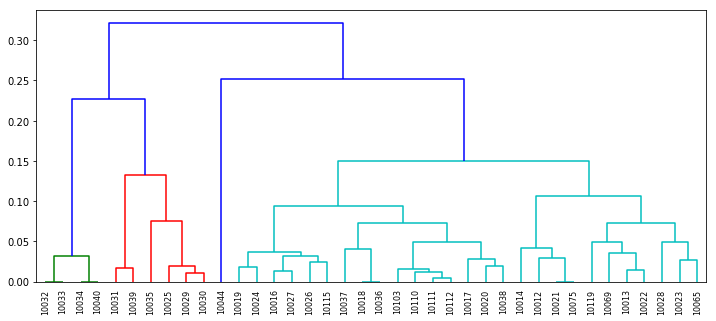

In [255]:
# Now build and cut the hierarchical tree to group zipcode regions where the restaraunt types are similar
Threshhold = 0.16

linked = linkage(pca.components_.T, 'average')
labelList = list(df_grouped.index)
group_list = cut_tree(linked,height=Threshhold)
df_grouped['label'] =  group_list

fig,ax = plt.subplots(figsize=(12, 5))  
tree = dendrogram(linked,  
            orientation='top',
            get_leaves=True,    
            distance_sort='descending',
            show_leaf_counts=True,ax=ax,color_threshold=Threshhold)
ax.set_xticklabels([labelList[x]for x in a['leaves']],rotation = 90) 

plt.show()  

In [265]:
Restaurant_category  = df_grouped.groupby('label').sum().T
Restaurant_kinds = len(set(Restaurant_category))
Restaurant_category['sum'] = Restaurant_category.sum(axis = 1)

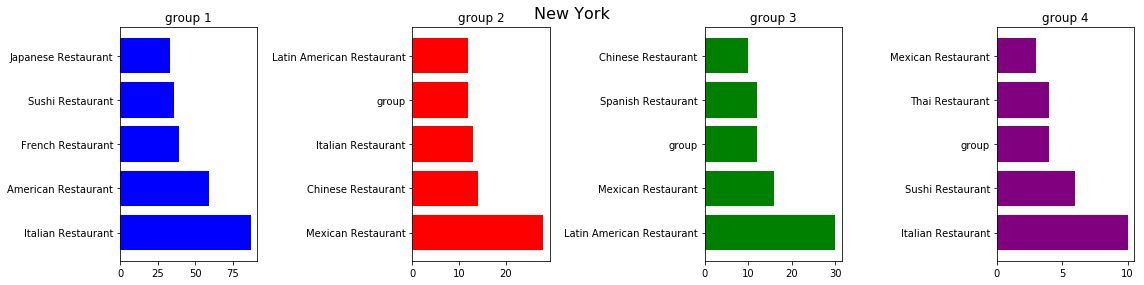

In [264]:
fig,ax = plt.subplots(1,Restaurant_kinds,figsize = (Restaurant_kinds*4,4)) 
for i in range(Restaurant_kinds):
    data = Restaurant_category.sort_values(i,ascending = False).head(5)[i]
    ax[i].set_title('group '+str(i+1))
    ax[i].barh(np.arange(len(data)),width = data,color = dict_color[i])
    ax[i].set_yticks(np.arange(len(data)))
    ax[i].set_yticklabels(list(data.index))
fig.suptitle('New York',fontsize = 16)
plt.tight_layout()

In [270]:
# Filter out those locations that have no returned venues
grouped_idx = df_grouped.index
dict_color = {0:'blue',1:'red',2:'green',3:'purple',4:'orange'}

map_city = folium.Map(location=[df_locations.loc[grouped_idx].Lat.mean(), df_locations.loc[grouped_idx].Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=600,height=600)

for lat, lng, region, col, size in zip(df_locations.loc[grouped_idx]['Lat'], df_locations.loc[grouped_idx]['Lng'], df_locations.loc[grouped_idx].index,[dict_color[c] for c in  kmeans.labels_],df_grouped.sum(axis = 1)):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/2,
        popup=label,
        color='',
        fill=True,
        fill_color=col,
        fill_opacity=0.5,
        parse_html=True).add_to(map_city)  
    
map_city.save('NYC_final.html')

In [278]:
IFrame(src='NYC_final.html',height=600, width=600)

##### Now you have a better idea about the city. If you want to go shopping, downtown has more stores; Latino food? Go north.
